In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
from utils.utils import get_path
from utils.io_utils import load_multiple_res
from utils.pd_utils import get_persistent_feature_id, filter_dgms, compute_outlier_scores
from utils.fig_utils import full_dist_to_print, full_dist_to_color, dataset_to_print, dist_to_print, dist_to_color, plot_edges_on_scatter
from vis_utils.plot import plot_scatter
from vis_utils.utils import load_dict, save_dict
from vis_utils.loaders import load_dataset
from persim import plot_diagrams
import os
import numpy as np
import copy
import umap

env: CUDA_VISIBLE_DEVICES=1


In [2]:
style_file = "utils.style"
plt.style.use(style_file)

In [3]:
root_path = get_path("data")
fig_path = os.path.join(root_path, "figures")

# Fig Malaria

In [4]:
# hyperparameters
k = 15
dataset = "mca_ss2"
x, y, sknn, pca2, d = load_dataset(root_path, dataset, k)
print(x.shape)
seeds = [0, 1, 2]

(1787, 5156)


In [5]:
# load umap embedding of malaria dataset
umap_file_name = f"{dataset}_umap_correlation_k_10_min_dist_1.0_spread_2_seed_2_init_spectral.pkl"

try:
    embd = load_dict(os.path.join(root_path, dataset, umap_file_name)).embedding_
except FileNotFoundError:
    umapper = umap.UMAP(n_neighbors=10,
                        metric="correlation",
                        verbose=True,
                        min_dist=1.0,
                        spread=2,
                        random_state=2,
                        init = "spectral",
                        )
    _ = umapper.fit_transform(x)
    save_dict(umapper, os.path.join(root_path, dataset, umap_file_name))

    embd = load_dict(os.path.join(root_path, dataset, umap_file_name)).embedding_

In [6]:
# distances for illustration of representatives on malaria dataset
distances_corr = {
    "correlation": [{}],
    "dtm": [
        {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "eff_res":[
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
    ],
    "diffusion": [
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
    ]
}
for distance in distances_corr:
    if distance in ["euclidean", "cosine", "correlation"]:
        continue
    for dist_kwargs in distances_corr[distance]:
        dist_kwargs["input_distance"] = "correlation"

In [20]:
# load PH results
all_res_corr = load_multiple_res(datasets=dataset, n=None, embd_dims=None, sigmas=None, distances=distances_corr, seeds=seeds, root_path=root_path, n_threads=1)

Done with mca_ss2 None correlation n_outliers=0, perturbation=None
Done with mca_ss2 None dtm_k_15_p_dtm_inf_p_radius_inf_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None eff_res_corrected_True_weighted_False_k_15_disconnect_True_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None diffusion_k_15_t_64_kernel_sknn_include_self_False_input_distance_correlation n_outliers=0, perturbation=None


In [21]:
''# compute detection scores
compute_outlier_scores(all_res_corr, dim=1, n_features=2)

{'correlation': {'correlation': array([0.21183256, 0.21183256, 0.21183256])},
 'dtm': {'dtm_k_15_p_dtm_inf_p_radius_inf_input_distance_correlation': array([0.88185759, 0.88185759, 0.88185759])},
 'eff_res': {'eff_res_corrected_True_weighted_False_k_15_disconnect_True_input_distance_correlation': array([0.93889885, 0.93889885, 0.93889885])},
 'diffusion': {'diffusion_k_15_t_64_kernel_sknn_include_self_False_input_distance_correlation': array([0.98027049, 0.98027049, 0.98027049])}}

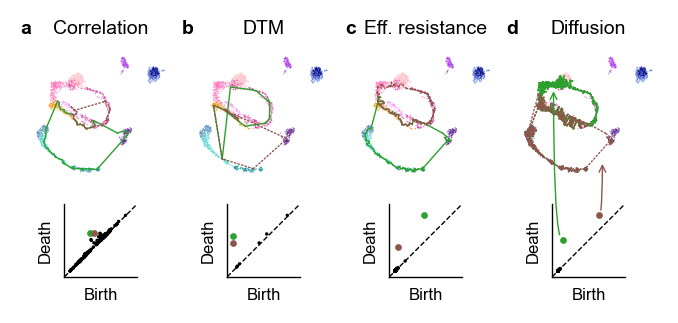

In [22]:
# plot figure
highlight_colors = [plt.get_cmap("tab10")(i) for i in [2, 5]]
size = 6

letters = "abcdefgh"
titles = ["Correlation", "DTM", "Eff. resistance", "Diffusion"]
linestyles = ["solid", "dotted"]

# postitions and angles for the arrows
head_positions = [[(0.09, 0.45), (0.4, 0.6)],
                  [(0.4, 0.75), (0.09, 0.45)],
                  [(0.6, 0.4), (0.2, 0.75)],
                  [(0.25, 0.7), (0.6, 0.2)],
                  ]

angles =[[(45, -60), (45, -60)],
         [(-20, 40), (60, 130)],
         [(0, 90), (0, 90)],
         [(0, 90), (0, 90)],
         ]

mosaic = """
abcd
efgh"""
fig, ax_dict = plt.subplot_mosaic(mosaic=mosaic, height_ratios=[1, 0.5], figsize=(3.25, 1.5))

ax = np.array([[ax_dict[letter] for letter in row] for row in mosaic.split("\n") if row])

# for each distance plot the scatter plot and the persistence diagram
for i, dist in enumerate(all_res_corr):
    full_dist = list(all_res_corr[dist].keys())[0]
    
    res = all_res_corr[dist][full_dist][0]
    
    # persistence diagram
    plot_diagrams(res["dgms"],
              ax=ax[1, i],
              plot_only=[1], 
              size=size, 
              color="k",
              colormap=style_file, # necessary bc plot_diagrams uses the colormap as mpl style
              )
    ax[1, i].legend().set_visible(False)
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])
    ax[1, i].set_xticklabels([])
    ax[1, i].set_yticklabels([])
    ax[0, i].set_title(titles[i])
    ax[0, i].set_title(
        letters[i],
        loc="left",
        ha="right",
        fontweight="bold",
)        
    # scattter plots and representatives    
    # get indices of the 2 most persistent loops
    idx = [get_persistent_feature_id(res, dim=1, m=m+1) for m in range(2)] 

    plot_scatter(ax=ax[0, i],
                 x=embd,
                 y=[d["cluster_colors"][i] for i in y],
                 scalebar=False,
                 alpha=0.5,)
    
    for j, id in enumerate(idx):
        ax[1, i].scatter(*res["dgms"][1][id].T,
                         color=highlight_colors[j],
                         s=size+2
                         )
        plot_edges_on_scatter(ax=ax[0, i],
                             edge_idx = res["cycles"][1][id],
                             x=embd,
                             color=highlight_colors[j],
                             linewidth=0.5,
                             linestyle=linestyles[j],
                             )
        
        # plot arrow from scatter plot to persistence diagram
        if i == 3:
            annot = plt.Annotation(
            "",
            xy=head_positions[i][j],
            xycoords=ax[0, i].transAxes,
            xytext=(res["dgms"][1][id]), 
            textcoords=ax[1, i].transData,
            arrowprops=dict(arrowstyle="->", linewidth=0.5, color=highlight_colors[j], connectionstyle=f"angle3,angleA={angles[i][j][0]},angleB={angles[i][j][1]}"),
             )
            ax[1, i].add_artist(annot)

fig.savefig(os.path.join(fig_path, "fig_malaria.pdf"))

# Fig all single-cell datasets

In [41]:
# hyperparameters
distances = {
    "euclidean": [{}],
    "correlation": [{}],
    "fermat": [
        {"p": 1},
        {"p": 2},
        {"p": 3},
        {"p": 5},
        {"p": 7}
    ],
    "dtm": [
            {"k": 4, "p_dtm": 2, "p_radius": 1},
            {"k": 4, "p_dtm": np.inf, "p_radius": 1},
            {"k": 15, "p_dtm": 2, "p_radius": 1},
            {"k": 15, "p_dtm": np.inf, "p_radius": 1},
            {"k": 100, "p_dtm": 2, "p_radius": 1},
            {"k": 100, "p_dtm": np.inf, "p_radius": 1},

            {"k": 4, "p_dtm": 2, "p_radius": 2},
            {"k": 4, "p_dtm": np.inf, "p_radius": 2},
            {"k": 15, "p_dtm": 2, "p_radius": 2},
            {"k": 15, "p_dtm": np.inf, "p_radius": 2},
            {"k": 100, "p_dtm": 2, "p_radius": 2},
            {"k": 100, "p_dtm": np.inf, "p_radius": 2},

            {"k": 4, "p_dtm": 2, "p_radius": np.inf},
            {"k": 4, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 15, "p_dtm": 2, "p_radius": np.inf},
            {"k": 15, "p_dtm": np.inf, "p_radius": np.inf},
            {"k": 100, "p_dtm": 2, "p_radius": np.inf},
            {"k": 100, "p_dtm": np.inf, "p_radius": np.inf},
    ],
    "tsne_embd": [
        {"perplexity": 8, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},
        {"perplexity": 30, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},
        {"perplexity": 333, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True}
    ],
    "umap_embd": [
        {"k": 100, "n_epochs": 750, "min_dist": 0.1},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
    "spectral": [
        {"k": 15, "normalization": "sym", "n_evecs": 2, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 5, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 10, "weighted": False},
    ],
}

datasets = ["mca_ss2", "neurosphere_gopca_small", "hippocampus_gopca_small", "pallium_scVI_IPC_small", "HeLa2_gopca", "pancreas_gopca"]

seeds = [0, 1, 2]

n_loops = {dataset: 1 if dataset != "mca_ss2" else 2 for dataset in datasets}

In [42]:
# make copy of the distance dict with correlation as input distance for malaria dataset
distances_corr = copy.deepcopy(distances)
for distance in distances_corr:
    if distance in ["euclidean", "cosine", "correlation"]:
        continue
    for dist_kwargs in distances_corr[distance]:
        dist_kwargs["input_distance"] = "correlation"
        if "metric" in dist_kwargs:
            del dist_kwargs["metric"]

In [43]:
# load PH results (using correlation as input distance for malaria dataset)
all_res = {}
for dataset in datasets:
    dists = distances if dataset != "mca_ss2" else distances_corr
    all_res[dataset] = load_multiple_res(datasets=dataset, 
                                         n=None, 
                                         embd_dims=None,
                                         sigmas=None,
                                         distances=dists,
                                         seeds=seeds,
                                         root_path=root_path,
                                         n_threads=1)

Done with mca_ss2 None euclidean n_outliers=0, perturbation=None
Done with mca_ss2 None correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_2_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_3_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_5_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_7_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None dtm_k_4_p_dtm_2_p_radius_1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None dtm_k_4_p_dtm_inf_p_radius_1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None dtm_k_15_p_dtm_2_p_radius_1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None dtm_k_15_p_dtm_inf_p_radius_1_input_distance_corre

In [44]:
# thresholding 
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, binary=True, dim=1)

In [45]:
# compute detection scores
outlier_scores = {}
for dataset in datasets:
    outlier_scores[dataset] = compute_outlier_scores(all_res[dataset], n_features=n_loops[dataset], dim=1)

In [46]:
# select best hyperparameter setting for each distance on each dataset
best_method = {}
for dataset in datasets:
    best_full_dist_on_dataset = {}
    for dist in distances:
        best_mean = 0
        for full_dist in outlier_scores[dataset][dist]:
            if dataset != "mca_ss2":
                full_dist = full_dist.removesuffix("_input_distance_correlation")
            mean = outlier_scores[dataset][dist][full_dist].mean()
            if best_mean <= mean:
                best_mean = mean
                best_full_dist_on_dataset[dist] = full_dist
    best_method[dataset] = best_full_dist_on_dataset

In [57]:
# results of manual evaluation of the correctness of the most persistent detected loop
correct_detection = {
    "mca_ss2": {
        "correlation": False,
        "fermat": False,
        "dtm": False,
        "tsne_embd": False,
        "umap_embd": False,
        "eff_res": True,
        "diffusion": True,
        "spectral": True,
    },
    "neurosphere_gopca_small": {
        "euclidean": True,
        "fermat": True,
        "dtm": True,
        "tsne_embd": True,
        "umap_embd": True,
        "eff_res": True,
        "diffusion": True,
        "spectral": True,
    },
    "hippocampus_gopca_small": {
        "euclidean": True,
        "fermat": False,
        "dtm": True,
        "tsne_embd": True,
        "umap_embd": True,
        "eff_res": True,
        "diffusion": True,
        "spectral": True,
    },
    "pallium_scVI_IPC_small": {
        "euclidean": True,
        "fermat": True,
        "dtm": True,
        "tsne_embd": True,
        "umap_embd": False,
        "eff_res": True,
        "diffusion": True,
        "spectral": True,
    },
    "HeLa2_gopca": {
        "euclidean": False,
        "fermat": False,
        "dtm": True,
        "tsne_embd": True,
        "umap_embd": True,
        "eff_res": True,
        "diffusion": False,
        "spectral": True,
    },
    "pancreas_gopca": {
        "euclidean": False,
        "fermat": False,
        "dtm": False,
        "tsne_embd": True,
        "umap_embd": True,
        "eff_res": True,
        "diffusion": False,
        "spectral": True,
    },
}

In [58]:
# for inspection of the best methods per dataset --> Table S2
best_method["pancreas_gopca"]

{'euclidean': 'euclidean',
 'correlation': 'correlation',
 'fermat': 'fermat_p_7',
 'dtm': 'dtm_k_100_p_dtm_inf_p_radius_inf',
 'tsne_embd': 'tsne_embd_perplexity_8_n_epochs_500_n_early_epochs_250_rescale_tsne_True',
 'umap_embd': 'umap_embd_k_100_n_epochs_750_min_dist_0.1',
 'eff_res': 'eff_res_corrected_True_weighted_False_k_100_disconnect_True',
 'diffusion': 'diffusion_k_15_t_64_kernel_sknn_include_self_False',
 'spectral': 'spectral_k_15_normalization_sym_n_evecs_5_weighted_False'}

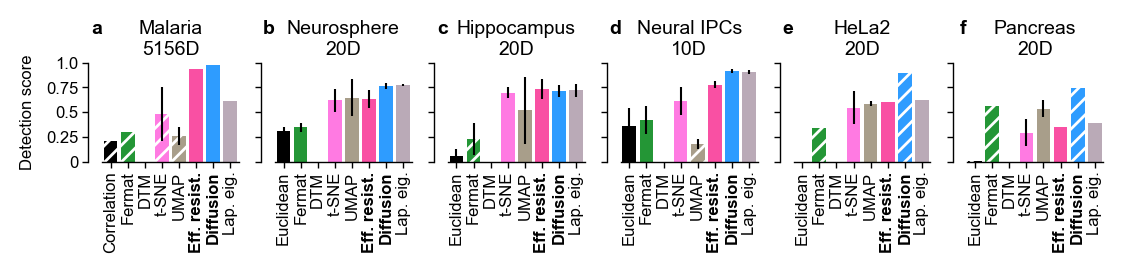

In [59]:
# plot figure
plt.rcParams.update({'hatch.color': 'w'})
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(5.5, 1.25))

dataset_dim = {"mca_ss2": 5156,
               "neurosphere_gopca_small": 20,
               "hippocampus_gopca_small": 20,
                "pallium_scVI_IPC_small": 10,
                "HeLa2_gopca": 20,    
                "pancreas_gopca": 20} 

letters = "abcdefgh"

for i, dataset in enumerate(datasets):
    cax = ax[i]
    shift = 0
    for j, dist in enumerate(best_method[dataset]):
        full_dist = best_method[dataset][dist]           
        full_dist_for_color = full_dist.removesuffix("_input_distance_correlation")
        
        # for malaria, we plot correlation, for the others we plot euclidean distance. The shift argument handles selecting the correct one
        if dataset == "mca_ss2":
            if full_dist == "euclidean":
                shift = -1
                continue
            elif full_dist == "correlation":
                full_dist_for_color = "euclidean"
                full_dist_for_print = "correlation"
        else:
            if full_dist == "correlation":
                shift = -1
                continue
        
        j += shift  
        
        
        mean = outlier_scores[dataset][dist][full_dist].mean()
        std = outlier_scores[dataset][dist][full_dist].std()        
        
        if dist == "umap_embd":
            full_dist_for_color += "_metric_euclidean"
            
        if dataset == "mca_ss2" and dist == "correlation":
            dist_for_color = "euclidean"
        else:
            dist_for_color = dist
        
        # plot the bar with hatching if detection was deemed incorrect
        if correct_detection[dataset][dist]:
            cax.bar(j, mean, width=0.8, yerr=std, label=dist, color=dist_to_color[dist_for_color])
        else:
            cax.bar(j, mean, width=0.8, yerr=std, label=dist, color=dist_to_color[dist_for_color], hatch="////", alpha=1)
         
        # prettify panel
        cax.set_ylim(0.0, 1.0)
        cax.set_xticks([])
        cax.set_xticklabels([])
    
        cax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        
        if i==0:
            cax.set_ylabel("Detection score")
            cax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])
        else:
            cax.set_yticklabels([])

        cax.set_title(dataset_to_print[dataset]+f"\n{dataset_dim[dataset]}D")
        #cax.set_title(dataset_to_print[dataset]+f" ({dataset_dim[dataset]}D)")
        cax.set_title(
            letters[i]+"\n",
            loc="left",
            fontweight="bold",
            ha="right",
        )

    cax.spines['left'].set_position(('outward', 5))
    cax.set_xlim(-0.5, len(best_method[dataset])-1.5)
       
    cax.set_xticks(range(len(best_method[dataset])-1))
    
    # add the distance names as xlables, use correlation for malaraia, euclidean for the others
    if i==0:
        cax.set_xticklabels(["Correlation"]+[dist_to_print[dist] for dist in list(best_method["neurosphere_gopca_small"])[2:]], rotation=90)
    else:
        cax.set_xticklabels(["Euclidean"]+[dist_to_print[dist] for dist in list(best_method["neurosphere_gopca_small"])[2:]], rotation=90)
        
    labels = cax.get_xticklabels()
    labels[-3].set_weight("bold")
    labels[-2].set_weight("bold")

fig.savefig(os.path.join(fig_path, "fig_scRNAseq_sep_filtered_dims.pdf"))    

# Fig with all methods for all datasets

In [61]:
# hyperparameters
distances = {
    "euclidean": [{}],
    "correlation": [{}],
    "fermat": [
        {"p": 2},
        {"p": 3},
        {"p": 5},
        {"p": 7}
    ],
    "core": [
        {"k": 15},
        {"k": 100}],
    "sknn_dist": [
        {"k": 15},
        {"k": 100}
    ],

    "tsne": [
         {"perplexity": 30},
         {"perplexity": 200},
         {"perplexity": 333}
    ],
    "umap": [
         {"k": 100, "use_rho": True, "include_self": True},
         {"k": 999, "use_rho": True, "include_self": True},
    ],
    "tsne_embd": [
        {"perplexity": 8, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},
        {"perplexity": 30, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True},
        {"perplexity": 333, "n_epochs": 500, "n_early_epochs": 250, "rescale_tsne": True}
    ],
    "umap_embd": [
        {"k": 15, "n_epochs": 750, "min_dist": 0.1},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
    ],
    "diffusion": [
        {"k": 15, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 8, "kernel": "sknn", "include_self": False},
        {"k": 15, "t": 64, "kernel": "sknn", "include_self": False},
        {"k": 100, "t": 64, "kernel": "sknn", "include_self": False},
    ],
    "spectral": [
        {"k": 15, "normalization": "sym", "n_evecs": 2, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 5, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 10, "weighted": False},
    ],
}

datasets = ["mca_ss2", "neurosphere_gopca_small", "hippocampus_gopca_small", "pallium_scVI_IPC_small", "HeLa2_gopca", "pancreas_gopca"]

seeds = [0, 1, 2]

n_loops = {dataset: 1 if dataset != "mca_ss2" else 2 for dataset in datasets}

In [62]:
# add correlation as input distance as malaria will use it 
distances_corr = copy.deepcopy(distances)
for distance in distances_corr:
    if distance in ["euclidean", "cosine", "correlation"]:
        continue
    for dist_kwargs in distances_corr[distance]:
        dist_kwargs["input_distance"] = "correlation"
        if "metric" in dist_kwargs:
            del dist_kwargs["metric"]

In [63]:
# load the PH results (using correlation as input distance for malaria)
all_res = {}
for dataset in datasets:
    dists = distances if dataset != "mca_ss2" else distances_corr
    all_res[dataset] = load_multiple_res(datasets=dataset, 
                                         n=None, 
                                         embd_dims=None,
                                         sigmas=None,
                                         distances=dists,
                                         seeds=seeds,
                                         root_path=root_path,
                                         n_threads=1)

Done with mca_ss2 None euclidean n_outliers=0, perturbation=None
Done with mca_ss2 None correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_2_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_3_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_5_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None fermat_p_7_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None core_k_15_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None core_k_100_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None sknn_dist_k_15_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None sknn_dist_k_100_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None tsne_perplexity_30_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_s

In [64]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, binary=True, dim=1)

In [65]:
# compute the detection scores
outlier_scores = {}
for dataset in datasets:
    outlier_scores[dataset] = compute_outlier_scores(all_res[dataset], n_features=n_loops[dataset], dim=1)

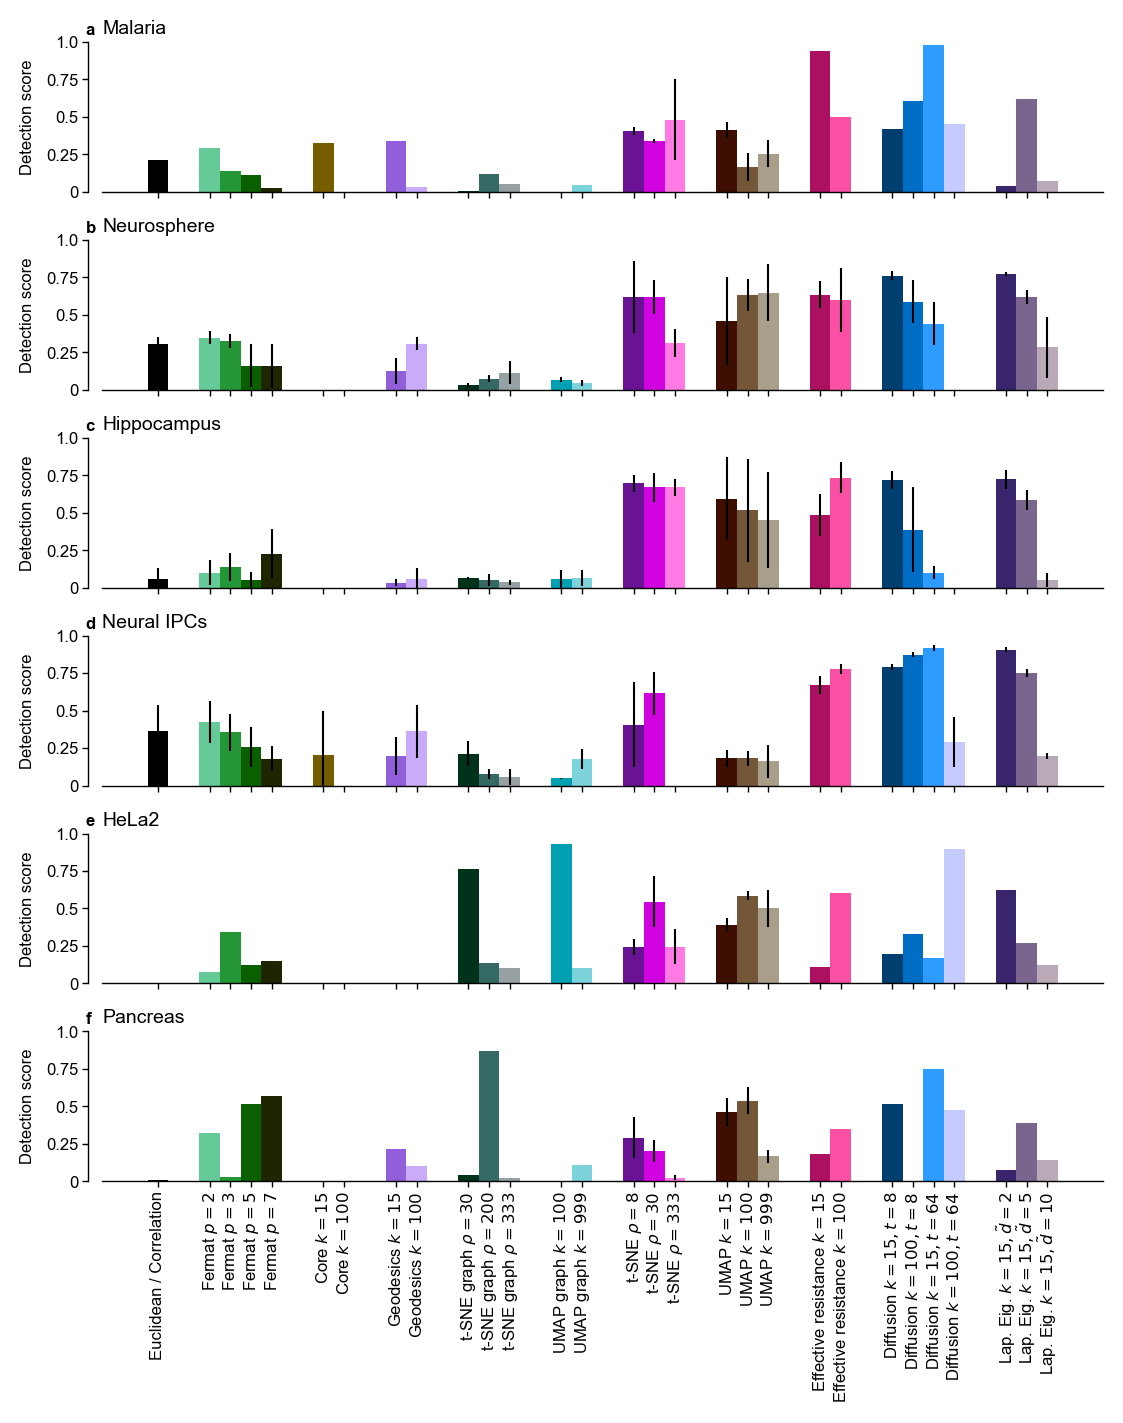

In [66]:
# plot figure
plt.rcParams.update({'hatch.color': 'w'})
fig, ax = plt.subplots(ncols=1, nrows=len(datasets), figsize=(5.5, 7))

bar_width = 0.2
sep = 1.5 * bar_width

for i, dataset in enumerate(datasets):
    # one row per dataset
    cax = ax[i]
    x_vals = [0]
    shift = 0
    full_dists = []
    for j, dist in enumerate(outlier_scores[dataset]):    
        # show correlation distance for malaria and euclidean distance for the other dataset. The shift handles the correct distance selection.
        if dataset == "mca_ss2":
            if dist == "euclidean":
                shift = -1
                continue
            elif dist == "correlation":
                full_dist_for_color = "euclidean"
                full_dist_for_print = "correlation"
        else:
            if dist == "correlation":
                shift = -1
                continue
                
        j+=shift
        x_val = x_vals[-1] + sep
        
        # plot all hyperparameter results for this distance in on block
        for k, full_dist in enumerate(outlier_scores[dataset][dist]):
            x_val += bar_width
            x_vals.append(x_val)

            full_dist_for_color = full_dist.removesuffix("_input_distance_correlation")
                            
            if dist == "umap_embd":
                full_dist_for_color += "_metric_euclidean"
                
            if dataset == "mca_ss2" and dist == "correlation":
                full_dist_for_color = "euclidean"
            else:
                full_dist_for_color = full_dist_for_color
                
            full_dists.append(full_dist_for_color)

            cax.bar(x_val, 
                   outlier_scores[dataset][dist][full_dist].mean(), 
                   bar_width, 
                   yerr=outlier_scores[dataset][dist][full_dist].std(), 
                   label=full_dist_to_print[full_dist_for_color],
                   color = full_dist_to_color[full_dist_for_color]
                   )
        
    # prettify the panel
    cax.set_ylim(0.0, 1.0)
    cax.set_xticks([])
    cax.set_xticklabels([])

    cax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    
    cax.set_ylabel("Detection score")
    cax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])

    cax.set_title(dataset_to_print[dataset], loc="left")
    cax.text(
        -0.2,
        1.05,
        letters[i],
        fontweight="bold"
    )

    cax.spines['left'].set_position(('outward', 5))

    cax.set_xticks(x_vals[1:])
    
    if i == 5:
        cax.set_xticklabels(["Euclidean / Correlation"] + [full_dist_to_print[full_dist].replace("\n", " ") for full_dist in full_dists[1:]], 
                            rotation=90)

fig.savefig(os.path.join(fig_path, "fig_scRNAseq_sep_filtered_all_methods.pdf"))    

# Fig with all UMAP dimensions

In [67]:
# hyperparameters
distances = {
    "euclidean": [{}],
    "correlation": [{}],
    "umap_embd": [
        {"k": 15, "n_epochs": 750, "min_dist": 0.1},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1},
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 3},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 3},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 3},
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 5},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 5},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 5},
        {"k": 15, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 10},
        {"k": 100, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 10},
        {"k": 999, "n_epochs": 750, "min_dist": 0.1, "vis_dim": 10},
    ],
    "eff_res": [
        {"corrected": True, "weighted": False, "k": 15, "disconnect": True},
        {"corrected": True, "weighted": False, "k": 100, "disconnect": True},
    ],
    "spectral": [
        {"k": 15, "normalization": "sym", "n_evecs": 2, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 5, "weighted": False},
        {"k": 15, "normalization": "sym", "n_evecs": 10, "weighted": False},
    ],
}

datasets = ["mca_ss2", "neurosphere_gopca_small", "hippocampus_gopca_small", "pallium_scVI_IPC_small", "HeLa2_gopca", "pancreas_gopca"]

seeds = [0, 1, 2]

n_loops = {dataset: 1 if dataset != "mca_ss2" else 2 for dataset in datasets}

In [68]:
# add correlation as input distance as malaria will use it 
distances_corr = copy.deepcopy(distances)
for distance in distances_corr:
    if distance in ["euclidean", "cosine", "correlation"]:
        continue
    for dist_kwargs in distances_corr[distance]:
        dist_kwargs["input_distance"] = "correlation"
        if "metric" in dist_kwargs:
            del dist_kwargs["metric"]

In [69]:
# load the PH results (using correlation as input distance for malaria)
all_res = {}
for dataset in datasets:
    dists = distances if dataset != "mca_ss2" else distances_corr
    all_res[dataset] = load_multiple_res(datasets=dataset, 
                                         n=None, 
                                         embd_dims=None,
                                         sigmas=None,
                                         distances=dists,
                                         seeds=seeds,
                                         root_path=root_path,
                                         n_threads=1)

Done with mca_ss2 None euclidean n_outliers=0, perturbation=None
Done with mca_ss2 None correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_15_n_epochs_750_min_dist_0.1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_100_n_epochs_750_min_dist_0.1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_999_n_epochs_750_min_dist_0.1_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_15_n_epochs_750_min_dist_0.1_vis_dim_3_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_100_n_epochs_750_min_dist_0.1_vis_dim_3_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_999_n_epochs_750_min_dist_0.1_vis_dim_3_input_distance_correlation n_outliers=0, perturbation=None
Done with mca_ss2 None umap_embd_k_15_n_epochs_750_min_dist_0.1_vis_dim_5_input_distance_correla

In [70]:
# filtering
dob = 1.25
all_res = filter_dgms(all_res, dob=dob, binary=True, dim=1)

In [71]:
# compute the detection scores
outlier_scores = {}
for dataset in datasets:
    outlier_scores[dataset] = compute_outlier_scores(all_res[dataset], n_features=n_loops[dataset], dim=1)

In [72]:
def umap_embd_full_dist_to_color(full_dist, full_dist_for_color):
    if not "vis_dim" in full_dist:
        full_dist_for_color += "_metric_euclidean"
    else:
        split = full_dist_for_color.split("_")
        index = split.index("vis")
        split[index] = "metric_euclidean_vis"
        full_dist_for_color = "_".join(split)
    return full_dist_for_color

In [73]:
import glasbey

extra_colors = glasbey.create_block_palette([3, 3, 3, 3, 3])

for i, full_dist in enumerate(all_res["mca_ss2"]["umap_embd"]):
    if "vis_dim" in full_dist:
        full_dist_for_color = full_dist.removesuffix("_input_distance_correlation")
        full_dist_for_color = umap_embd_full_dist_to_color(full_dist, full_dist_for_color)
        
        i = i +3 if i >= 3 else i
        full_dist_to_color[full_dist_for_color] = extra_colors[i]

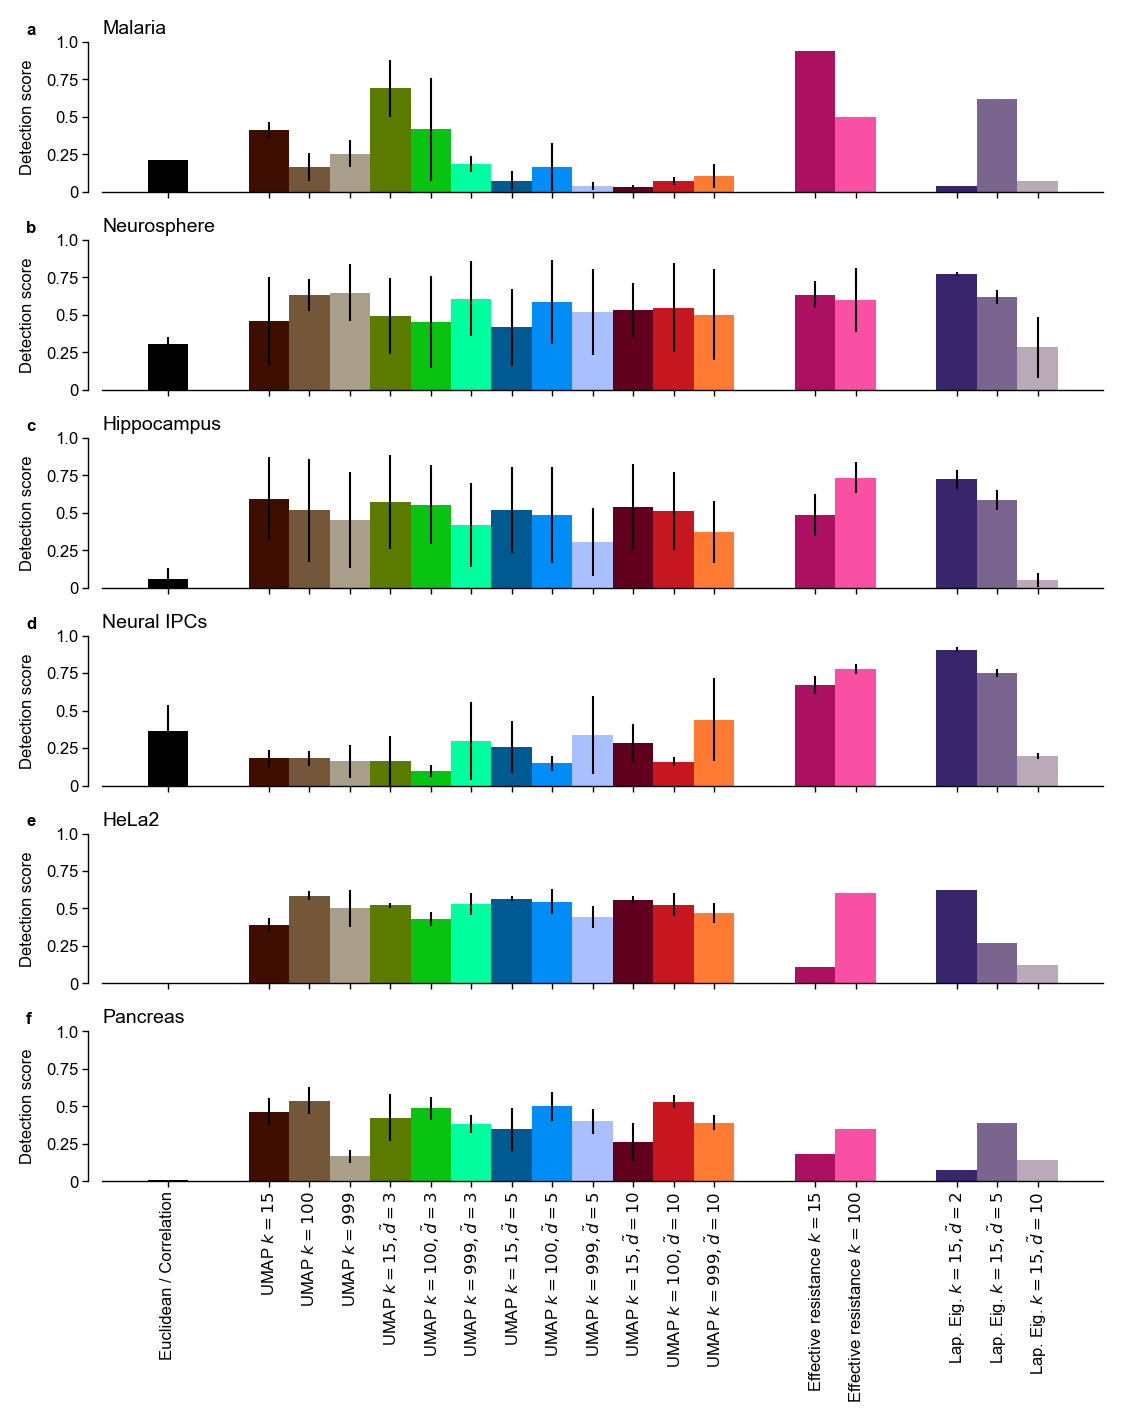

In [74]:
# plot figure
plt.rcParams.update({'hatch.color': 'w'})
fig, ax = plt.subplots(ncols=1, nrows=len(datasets), figsize=(5.5, 7))

bar_width = 0.2
sep = 1.5 * bar_width
letters = "abcdefgh"

for i, dataset in enumerate(datasets):
    # one row per dataset
    cax = ax[i]
    x_vals = [0]
    shift = 0
    full_dists = []
    for j, dist in enumerate(outlier_scores[dataset]):    
        # show correlation distance for malaria and euclidean distance for the other dataset. The shift handles the correct distance selection.
        if dataset == "mca_ss2":
            if dist == "euclidean":
                shift = -1
                continue
            elif dist == "correlation":
                full_dist_for_color = "euclidean"
                full_dist_for_print = "correlation"
        else:
            if dist == "correlation":
                shift = -1
                continue
                
        j+=shift
        x_val = x_vals[-1] + sep
        
        # plot all hyperparameter results for this distance in on block
        for k, full_dist in enumerate(outlier_scores[dataset][dist]):
            x_val += bar_width
            x_vals.append(x_val)

            full_dist_for_color = full_dist.removesuffix("_input_distance_correlation")
                            
            if dist == "umap_embd":
                full_dist_for_color = umap_embd_full_dist_to_color(full_dist, full_dist_for_color)
                    
                
            if dataset == "mca_ss2" and dist == "correlation":
                full_dist_for_color = "euclidean"
            else:
                full_dist_for_color = full_dist_for_color
                
            full_dists.append(full_dist_for_color)

            cax.bar(x_val, 
                   outlier_scores[dataset][dist][full_dist].mean(), 
                   bar_width, 
                   yerr=outlier_scores[dataset][dist][full_dist].std(), 
                   label=full_dist_to_print[full_dist_for_color],
                   color = full_dist_to_color[full_dist_for_color]
                   )
        
    # prettify the panel
    cax.set_ylim(0.0, 1.0)
    cax.set_xticks([])
    cax.set_xticklabels([])

    cax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    
    cax.set_ylabel("Detection score")
    cax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])

    cax.set_title(dataset_to_print[dataset], loc="left")
    cax.text(
        -0.2,
        1.05,
        letters[i],
        fontweight="bold"
    )

    cax.spines['left'].set_position(('outward', 5))

    cax.set_xticks(x_vals[1:])
    
    if i == 5:
        cax.set_xticklabels(["Euclidean / Correlation"] + [full_dist_to_print[full_dist].replace("\n", " ") for full_dist in full_dists[1:]], 
                            rotation=90)

fig.savefig(os.path.join(fig_path, "fig_scRNAseq_sep_filtered_all_UMAPs.pdf"), dpi=200)   